In [1]:
# pip install google-adk

In [2]:
import credentials
import os

In [3]:
GOOGLE_API_KEY = credentials.GOOGLE_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [10]:
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [5]:
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)

## Loop Workflows
### Architecture: Story Writing & Critique Loop

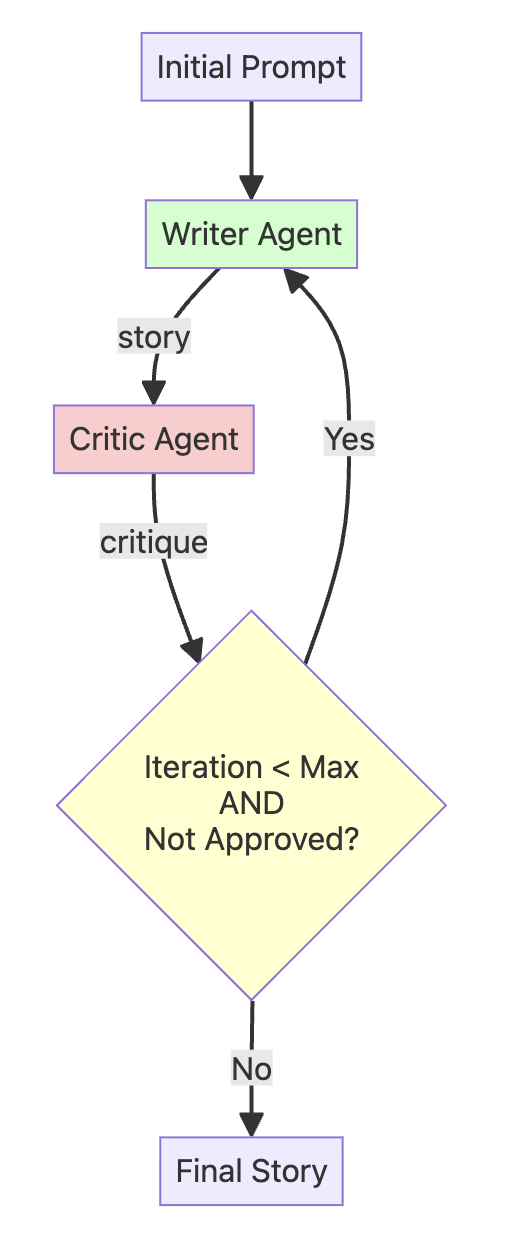

In [6]:
# This agent runs ONCE at the beginning to create the first draft.
initial_writer_agent = Agent(
    name="InitialWriterAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Based on the user's prompt, write the first draft of a short story (around 100-150 words).
    Output only the story text, with no introduction or explanation.""",
    output_key="current_story",  # Stores the first draft in the state.
)

print("✅ initial_writer_agent created.")

✅ initial_writer_agent created.


In [7]:
# This agent's only job is to provide feedback or the approval signal. It has no tools.
critic_agent = Agent(
    name="CriticAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a constructive story critic. Review the story provided below.
    Story: {current_story}
    
    Evaluate the story's plot, characters, and pacing.
    - If the story is well-written and complete, you MUST respond with the exact phrase: "APPROVED"
    - Otherwise, provide 2-3 specific, actionable suggestions for improvement.""",
    output_key="critique",  # Stores the feedback in the state.
)

print("✅ critic_agent created.")

✅ critic_agent created.


In [8]:
# This is the function that the RefinerAgent will call to exit the loop.
def exit_loop():
    """Call this function ONLY when the critique is 'APPROVED', indicating the story is finished and no more changes are needed."""
    return {"status": "approved", "message": "Story approved. Exiting refinement loop."}


print("✅ exit_loop function created.")

✅ exit_loop function created.


In [11]:
# This agent refines the story based on critique OR calls the exit_loop function.
refiner_agent = Agent(
    name="RefinerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a story refiner. You have a story draft and critique.
    
    Story Draft: {current_story}
    Critique: {critique}
    
    Your task is to analyze the critique.
    - IF the critique is EXACTLY "APPROVED", you MUST call the `exit_loop` function and nothing else.
    - OTHERWISE, rewrite the story draft to fully incorporate the feedback from the critique.""",
    output_key="current_story",  # It overwrites the story with the new, refined version.
    tools=[
        FunctionTool(exit_loop)
    ],  # The tool is now correctly initialized with the function reference.
)

print("✅ refiner_agent created.")

✅ refiner_agent created.


In [12]:
# The LoopAgent contains the agents that will run repeatedly: Critic -> Refiner.
story_refinement_loop = LoopAgent(
    name="StoryRefinementLoop",
    sub_agents=[critic_agent, refiner_agent],
    max_iterations=2,  # Prevents infinite loops
)

# The root agent is a SequentialAgent that defines the overall workflow: Initial Write -> Refinement Loop.
root_agent = SequentialAgent(
    name="StoryPipeline",
    sub_agents=[initial_writer_agent, story_refinement_loop],
)

print("✅ Loop and Sequential Agents created.")

✅ Loop and Sequential Agents created.


In [13]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "Write a short story about a lighthouse keeper who discovers a mysterious, glowing map"
)


 ### Created new session: debug_session_id

User > Write a short story about a lighthouse keeper who discovers a mysterious, glowing map
InitialWriterAgent > The salt spray kissed Elias's weathered face as he polished the Fresnel lens, the rhythmic sweep of light a familiar comfort. For thirty years, his world had been the tower, the sea, and the stars. Tonight, though, something was different. Tucked beneath a loose stone near the spiral stairs, he found it: a vellum scroll, cool to the touch, etched with lines that pulsed with an ethereal, cerulean glow.

It wasn't any map he'd ever seen. Islands swirled like constellations, and rivers of light snaked across its surface. A single, bright star pulsed at its center, seeming to beckon him. Elias, a man who had seen countless shipwrecks and weathered every storm, felt a tremor of something akin to wonder. The sea had always held its secrets, but tonight, one had washed ashore, glowing in his solitary keep.
CriticAgent > The story establ